In [1]:
    import hopsworks
    import pandas as pd
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/226452


Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
iris_fg = fs.get_feature_group(name="iris", version=1)
query = iris_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="iris",
                                  version=1,
                                  description="Read from Iris flower dataset",
                                  labels=["variety"],
                                  query=query)

In [4]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (0.64s) 


KNeighborsClassifier(n_neighbors=2)

In [5]:
X_train

,sepal_length,sepal_width,petal_length,petal_width
1,5.600000,2.700000,4.200000,1.300000
5,6.400000,2.900000,4.300000,1.300000
6,7.200000,3.000000,5.800000,1.600000
7,6.300000,3.300000,4.700000,1.600000
8,5.200000,4.100000,1.500000,0.100000
...,...,...,...,...
147,6.400000,2.800000,5.600000,2.100000
148,5.000000,3.400000,1.600000,0.400000
149,6.082582,3.364015,4.798392,1.075227
150,4.568217,4.037557,1.462624,0.302874


In [6]:
y_train

,variety
1,Versicolor
5,Versicolor
6,Virginica
7,Versicolor
8,Setosa
...,...
147,Virginica
148,Setosa
149,Versicolor
150,Setosa


In [7]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [8]:
print(metrics)

{'Setosa': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9}, 'Versicolor': {'precision': 1.0, 'recall': 0.9166666666666666, 'f1-score': 0.9565217391304348, 'support': 12}, 'Virginica': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1-score': 0.9523809523809523, 'support': 10}, 'accuracy': 0.967741935483871, 'macro avg': {'precision': 0.9696969696969697, 'recall': 0.9722222222222222, 'f1-score': 0.9696342305037957, 'support': 31}, 'weighted avg': {'precision': 0.970674486803519, 'recall': 0.967741935483871, 'f1-score': 0.9678087223669273, 'support': 31}}


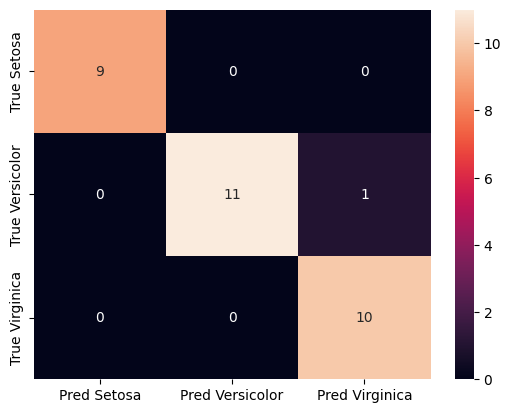

In [9]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                     ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [10]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="iris_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/iris_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="iris_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Iris Flower Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/18027 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/12374 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/480 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/226452/models/iris_model/3


Model(name: 'iris_model', version: 3)